# LoadCatsVsDogs

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

在AlexNet模型中,其输出层是1000,也就是说输出1000个类别中概率最大的一个.我们这里为了简单化处理,输出层为2个神经单元.这里使用的是Kaggle中的[CatsVsDogs](https://www.kaggle.com/c/dogs-vs-cats)数据集.可以通过[Kagge-api](https://github.com/Kaggle/kaggle-api)自行下载.下载完成后的目录为:

```
.
├── test1
└── train```

train:文件中放入的是25000个训练样本,每一张图片的名称格式为:```class.Number.jpg```.其中class为类别:```cat/dog```,Number为当前类别下的第N张图片.

test:文件中放入的是12500个测试样本,没有标签.


之前我们了解了TFRecord保存数据,但是对于现在的训练数据而言,我们的数据集是比较大的,那么TFRecord是无法高效率读写的.再后面的模型中我们甚至还会使用ImageNet中的数据集这个数据集更大,也是现在最流行的数据集,所以我们需要换一种将数据高效率读入的方法-```tf.data.Dataset```

### [1] Ndarray of Load Image Path 

首先为了做一步高效处理,我们先将所有的训练图片路径放入dnarray中,其中cat的label为0,dog的label为1.

具体操作如下:

In [2]:
def get_files(file_dir):
    """
    读取素有的文件,以ndarray的形式储存,以便于下面TF调用,
    data_path 的形状为 (m,1),这里的m指的是样本个数.
    labels 的形状为 (m,)

    Argus:
    ------
        file_dir: 数据路径,需要注意的是文件末尾不要有"/",因为下面"join()"中使用了'/'
    
    Returns:
    -------
        data_path: 包含所有路径的ndarray.
        labels: 包含所有标签,其中cat:0,dog:1.
    """
    data_path = []
    labels = []
    # 获取当前目录下的所有文件
    files = os.listdir(file_dir)

    for file in files:
        classes_name,_ = file.split('.',1) # 用"."分割,只划分一次,那么第一位就是类别名称
        # 划分类别,cat:0,dog:1
        if classes_name == 'cat':
            labels.append(0)
        else:
            labels.append(1)
        # 拼接所有图片的完整路径,接下去让TF调用读取.
        data_path.append(['/'.join((file_dir,file))])
    
    data_path = np.array(data_path)
    labels = np.array(labels)

    return data_path,labels

代码中需要注意的是,我们给予的主文件路径(也就是包含train/test1)的文件末尾不能有"/",因为我们在拼接的时候是使用```data_path.append(['/'.join((file_dir,file))])```,下面调用一个该函数.

In [3]:
file_dir = '/Users/huwang/Joker/Data_Set/catVSdot/train'
Data_path,Labels = get_files(file_dir)

print('The data path like :{}'.format(Data_path[0]))
print('The first label is :{}'.format(Labels[0]))

The data path like :['/Users/huwang/Joker/Data_Set/catVSdot/train/dog.8011.jpg']
The first label is :1


### [2] Read File

在获得了所有的训练样本的数据之后,我们可以使用TF读入这些图片,需要注意的是,我们这里暂时不拆分train/validation/test set.

我们可以使用:```tf.read_file(filename[0])```来读取图片,需要注意的是我们读取之后需要decode:```tf.image.decode_jpeg(image_string)```最后将其resize到目标的大小$(224,224)$.

**PS:**

> 实际上在AlexNet中训练样本要从$(256,256)$样本大小随机提取32个$(224,224)$的图片,然后将其水平翻转,还要做PCA但是不降维,那么这样的数据集就太多了,虽然可以一定程度上避免过拟合,增大训练样本.但是由于我们现在的训练硬件资源有限,所以我们直接将其resize到$(224,224)$的大小.

In [4]:
def _parse_function(filename,labels,n_h=224,n_w=224):
    """
    parse 函数,用于依照map进来的文件路径读取文件,再将其解码为jpeg,最终将图片resize到指定的大小

    Argus:
    ------
        filename: map 进来的图片文件路径
        labels: 对应的图片,放进来不做任何处理,只是为了下面代码dataset.shuffle保证样本与标签一一对应.
        n_h: resize的高
        n_w: resize的宽
    
    Returns:
    -------
        image_resize: 从新resize后的图片,形状为 (batch,n_h,n_w,n_c)
        labels: 传入进来的标签.
    """
    
    image_string = tf.read_file(filename[0])
    image_decoded = tf.image.decode_jpeg(image_string)
    # resize 图片大小,使用方式 ResizeMethod.BILINEAR.
    image_resize = tf.image.resize_images(image_decoded,(n_h,n_w))
    
    return image_resize,labels

代码中需要注意的是,我们将labels也传递了进来,实际上在先行函数中并不对其做任何操作,理由我们稍后解释.

另外对于```filename[0]```的解释是,我们的data_path是2-dim,当TF将数据map进该函数的时候filename的形状是"[path]",所以我们需要使用索引0.

Instructions for updating:
Colocations handled automatically by placer.


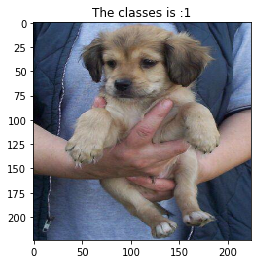

In [5]:
tf.reset_default_graph()
filename_path = tf.Variable(Data_path[0])
labels = Labels[0]
Image_data,Label_ = _parse_function(filename_path,labels)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    data = sess.run(Image_data)
    plt.imshow(data /255)
    plt.title('The classes is :{}'.format(Label_))
    plt.show()

### [3] Get Batch

现在我们已经知道了如何使用TF读取图片了已经resize到我们的目标大小,那么接下去就很简单了,只要将data_path,labels一一map进```_parse_function```函数即可.

In [6]:
def get_batch(features,labels,n_h,n_w,BATCH_SIZE,epochs):
    """
    使用tf.data.Dataset来读取图片
    更多详细请查看:https://www.tensorflow.org/guide/datasets

    Argus:
    -----
        features: ndarray,其中包含图片路径,shape:(m,1).
        labels: ndarray,其中包含图片标签,cat:0,dog:1.
        n_h: resize 的图片高
        n_w: resize 的图片宽
        BATCH_SIZE: 样本批次
        epochs: 迭代次数

    """
    # 在小数据量的时候可以不设置,
    # 但是大数据量由于可能会达到 tf.GraphDef 协议缓冲区的 2GB 上限,所以官方建议使用替代方案"tf.placeholder".
    features_placeholder = tf.placeholder(features.dtype,features.shape)
    labels_placeholder = tf.placeholder(labels.dtype,labels.shape)
    n_h_placeholder = tf.placeholder(tf.int32,labels.shape)
    n_w_placeholder = tf.placeholder(tf.int32,labels.shape)


    # 装进from_tensor_slices的所有维度必须一致.
    dataset = tf.data.Dataset.from_tensor_slices((features_placeholder,labels_placeholder,n_h_placeholder,n_w_placeholder))
    dataset = dataset.map(_parse_function) # 将划分的tensor一一执行_parse_function

    # shufle中的参数buffer_size指的是buffer的大小,每次TF取出一条,就会往buffer中增加一条,
    # buffer_size 表示的是buffer存放的item大小.更多详细查看https://juejin.im/post/5b855d016fb9a01a1a27d035
    # 不能设置过大,否则会Shuffle buffer filled.
    dataset = dataset.shuffle(1000) 
    dataset = dataset.batch(BATCH_SIZE) # 每次从buffer中拿出的batch size.

    ##########################################################
    # 如果不设置任何值表示无限重复的往buffer中或者队列中加入数据.    
    # 如果设置数值,则当队列重复次数达到该数值就不再重复,             
    # 此时如果再次调用iterator.get_next()就会抛出OutOfRangeError 
    # 一般都设置为无限重复                                     
    ##########################################################
    dataset = dataset.repeat() 

    # 创建迭代器初始化.
    iterator = dataset.make_initializable_iterator()
    # 依照官方建议,使用一个变量缓存iterator.get_next(),否则直接多次调用iterator.get_next(),速度会越来越慢,最终导致资源耗尽.
    next_element = iterator.get_next()
    with tf.Session() as sess:
        n_h = np.array([n_h for i in range(features.shape[0])])
        n_w = np.array([n_w for i in range(features.shape[0])])
        for _ in range(epochs):
            try:
                sess.run(iterator.initializer,feed_dict={features_placeholder:features,labels_placeholder:labels,
                n_h_placeholder:n_h,n_w_placeholder:n_w})
                img,label = sess.run(next_element) # 必须这样写,否则如果再次sess.run,队列就会混乱!!
                plt.imshow(img[0]/255)
                plt.title(label[0])
                plt.show()
            except tf.errors.OutOfRangeError:
                break

在代码中我贴上了TF官方关于Dataset类的教程,代码中有任何疑问可以[查看](https://www.tensorflow.org/guide/datasets).

(1) 我们需要创建4个placeholder,依次为:```features_placeholder```,```labels_placeholder```,```n_h_placeholder```,```n_w_placeholder```.

创建这4个placeholder的目的是:对于大样本而言,如果直接装入```tf.data.Dataset.from_tensor_slices```会发生协议缓冲区溢出.

<img src="../../../../../picture/202.png" height=600 width=600>

(2) 接着使用[tf.data.Dataset.from_tensor_slices](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices)将数据集划分,需要注意的是,里面各个参数的长度要一致,也就是说:第0维度的长度必须一致!

<img src="../../../../../picture/203.png" height=600 width=600>

(3) 接着我们将slices出来的结果一一map进函数```_parse_function```

(4) 为了防止模型过拟合,我们需要进行Shuffle:[dataset.shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle),其中参数是指buffer的大小,每次TF取出一条,就会往buffer中增加一条,buffer_size 表示的是buffer存放的item大小.更多详细查看[tf.data.Dataset.shuffle(buffer_size)中buffer_size的理解](https://juejin.im/post/5b855d016fb9a01a1a27d035)

<img src="../../../../../picture/204.png" height=600 width=600>

(5) 接着设置我们的batch size即每一个批次从buffer获取出来的数据量[dataset.batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle).

<img src="../../../../../picture/205.png" height=600 width=600>

(6) 我们需要设置[dataset.repeat()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat):如果不设置任何值表示无限重复的往buffer中或者队列中加入数据.如果设置数值,则当队列重复次数达到该数值就不再重复,此时如果再次调用iterator.get_next()就会抛出OutOfRangeError,当报出此错误意味着已经迭代出所有的数据,可以进行下一次epoch,所以在一般情况下我们会使用安全模式```try/except```.

(7) 接着创建初始化迭代器:[dataset.make_initializable_iterator()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#make_initializable_iterator),原因是我们使用的是placeholder的形式,需要将4个placeholder依次feed:

```python
sess.run(iterator.initializer,feed_dict{features_placeholder:features,labels_placeholder:labels,
                                        n_h_placeholder:n_h,n_w_placeholder:n_w})```



(8) 最后和TFRecord中一样,我们会多次调用迭代器,所以我们需要先初始化化一个```next_element = iterator.get_next()```,以防资源耗尽.

**Ps:**

需要注意的是:在调用```sess.run(next_element)```必须直接这样调用,因为每次一运行sess.run(next_element)这个语句,TensorFlow会自动的调取下一个批次的数据.不仅如此,只要sess.run一个把next_element作为输入的节点,也都会自动调取下一个批次的数据,也就是说```sess.run(next_element)```运行一次即可.

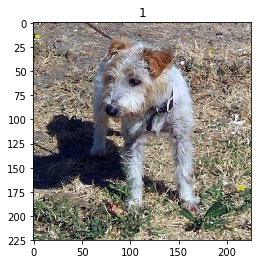

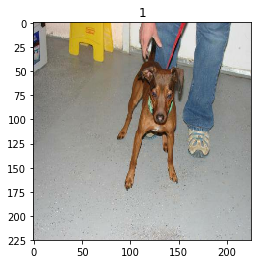

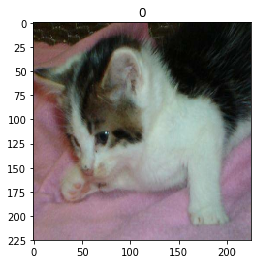

In [7]:
tf.reset_default_graph()
file_dir = '/Users/huwang/Joker/Data_Set/catVSdot/train'
data_path,labels = get_files(file_dir)
get_batch(data_path,labels,n_h=225,n_w=225,BATCH_SIZE=2,epochs=3)